In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
# If on colab
!pip install latentshift

In [3]:
import io
import os,sys
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import latentshift
import taming

/home/users/joecohen/.local/lib/python3.12/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


In [4]:
ae = latentshift.autoencoders.VQGAN(weights="faceshq", download=True)
face_model = latentshift.classifiers.FaceAttribute(download=True)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/users/joecohen/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users/joecohen/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/users/joecohen/.local/lib/python3.12/site-packages/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See http

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


/home/users/joecohen/workspace/latentshift/latentshift/attribute_classifier/BranchedTiny.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, m

In [6]:
!wget -q https://raw.githubusercontent.com/ieee8023/latentshift/main/sample_images/26187.jpg -O 26187.jpg

In [7]:
x = PIL.Image.open("./26187.jpg").convert('RGB') 
x = torchvision.transforms.ToTensor()(x)[None,...]

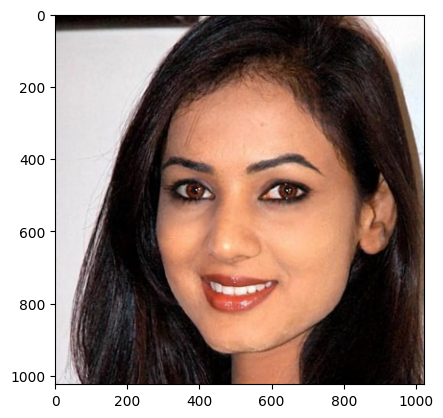

In [8]:
plt.imshow(x[0].permute(1, 2, 0).detach().numpy());

In [9]:
if torch.cuda.is_available():
    face_model = face_model.cuda()
    ae = ae.cuda()
    x = x.cuda()

In [11]:
face_model.targets

['blurry',
 'sideburns',
 'wearing_earrings',
 'bald',
 'goatee',
 'mustache',
 '5_o_clock_shadow',
 'arched_eyebrows',
 'no_beard',
 'heavy_makeup',
 'male',
 'wearing_lipstick',
 'black_hair',
 'high_cheekbones',
 'smiling',
 'mouth_slightly_open',
 'oval_face',
 'bushy_eyebrows',
 'attractive',
 'young',
 'gray_hair',
 'brown_hair',
 'blond_hair',
 'pale_skin',
 'chubby',
 'double_chin',
 'big_nose',
 'bags_under_eyes',
 'wearing_necklace',
 'wearing_necktie',
 'rosy_cheeks',
 'bangs',
 'wavy_hair',
 'straight_hair',
 'wearing_hat',
 'big_lips',
 'narrow_eyes',
 'pointy_nose',
 'receding_hairline',
 'eyeglasses']

In [12]:
base_model = latentshift.alignment.ModelWrapper(face_model, "smiling", sigmoid=True, rename_model='')

In [13]:
# biased model
# base_model = latentshift.alignment.ModelWrapper(face_model, [["smiling",1],["arched_eyebrows",0.3]], sigmoid=True, rename_model='')


In [14]:
models =[
    latentshift.alignment.ModelWrapper(face_model, target, sigmoid=True, rename_model='') for target in face_model.targets
]

In [15]:
attr = latentshift.cf.LatentShift(base_model, ae)
output = attr.attribute(
    x, 
    target=0,
    search_step_size=2,
    return_dicts=True,
    apply_sigmoid=False,
)[0]


Shift: 0, Pred: 0.97529536485672, pixel_diff: 0.0, sum*diff_pct: 4082.358154296875
Shift: -2, Pred: 0.9751901626586914, pixel_diff: 19.047279357910156, sum*diff_pct: 4082.358154296875
Shift: -5, Pred: 0.97505784034729, pixel_diff: 21.776657104492188, sum*diff_pct: 4082.358154296875
Shift: -8, Pred: 0.9749085307121277, pixel_diff: 25.09671401977539, sum*diff_pct: 4082.358154296875
Shift: -11, Pred: 0.974780261516571, pixel_diff: 27.989646911621094, sum*diff_pct: 4082.358154296875
Shift: -15, Pred: 0.9745494723320007, pixel_diff: 32.46029281616211, sum*diff_pct: 4082.358154296875
Shift: -19, Pred: 0.9743497967720032, pixel_diff: 36.353050231933594, sum*diff_pct: 4082.358154296875
Shift: -23, Pred: 0.9741350412368774, pixel_diff: 40.78343963623047, sum*diff_pct: 4082.358154296875
Shift: -28, Pred: 0.9738556146621704, pixel_diff: 46.07368469238281, sum*diff_pct: 4082.358154296875
Shift: -33, Pred: 0.9735894203186035, pixel_diff: 51.5486946105957, sum*diff_pct: 4082.358154296875
Shift: -39,

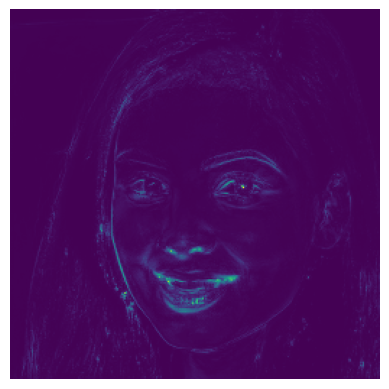

In [16]:
plt.imshow(output['heatmap'].mean(0));
plt.axis('off');

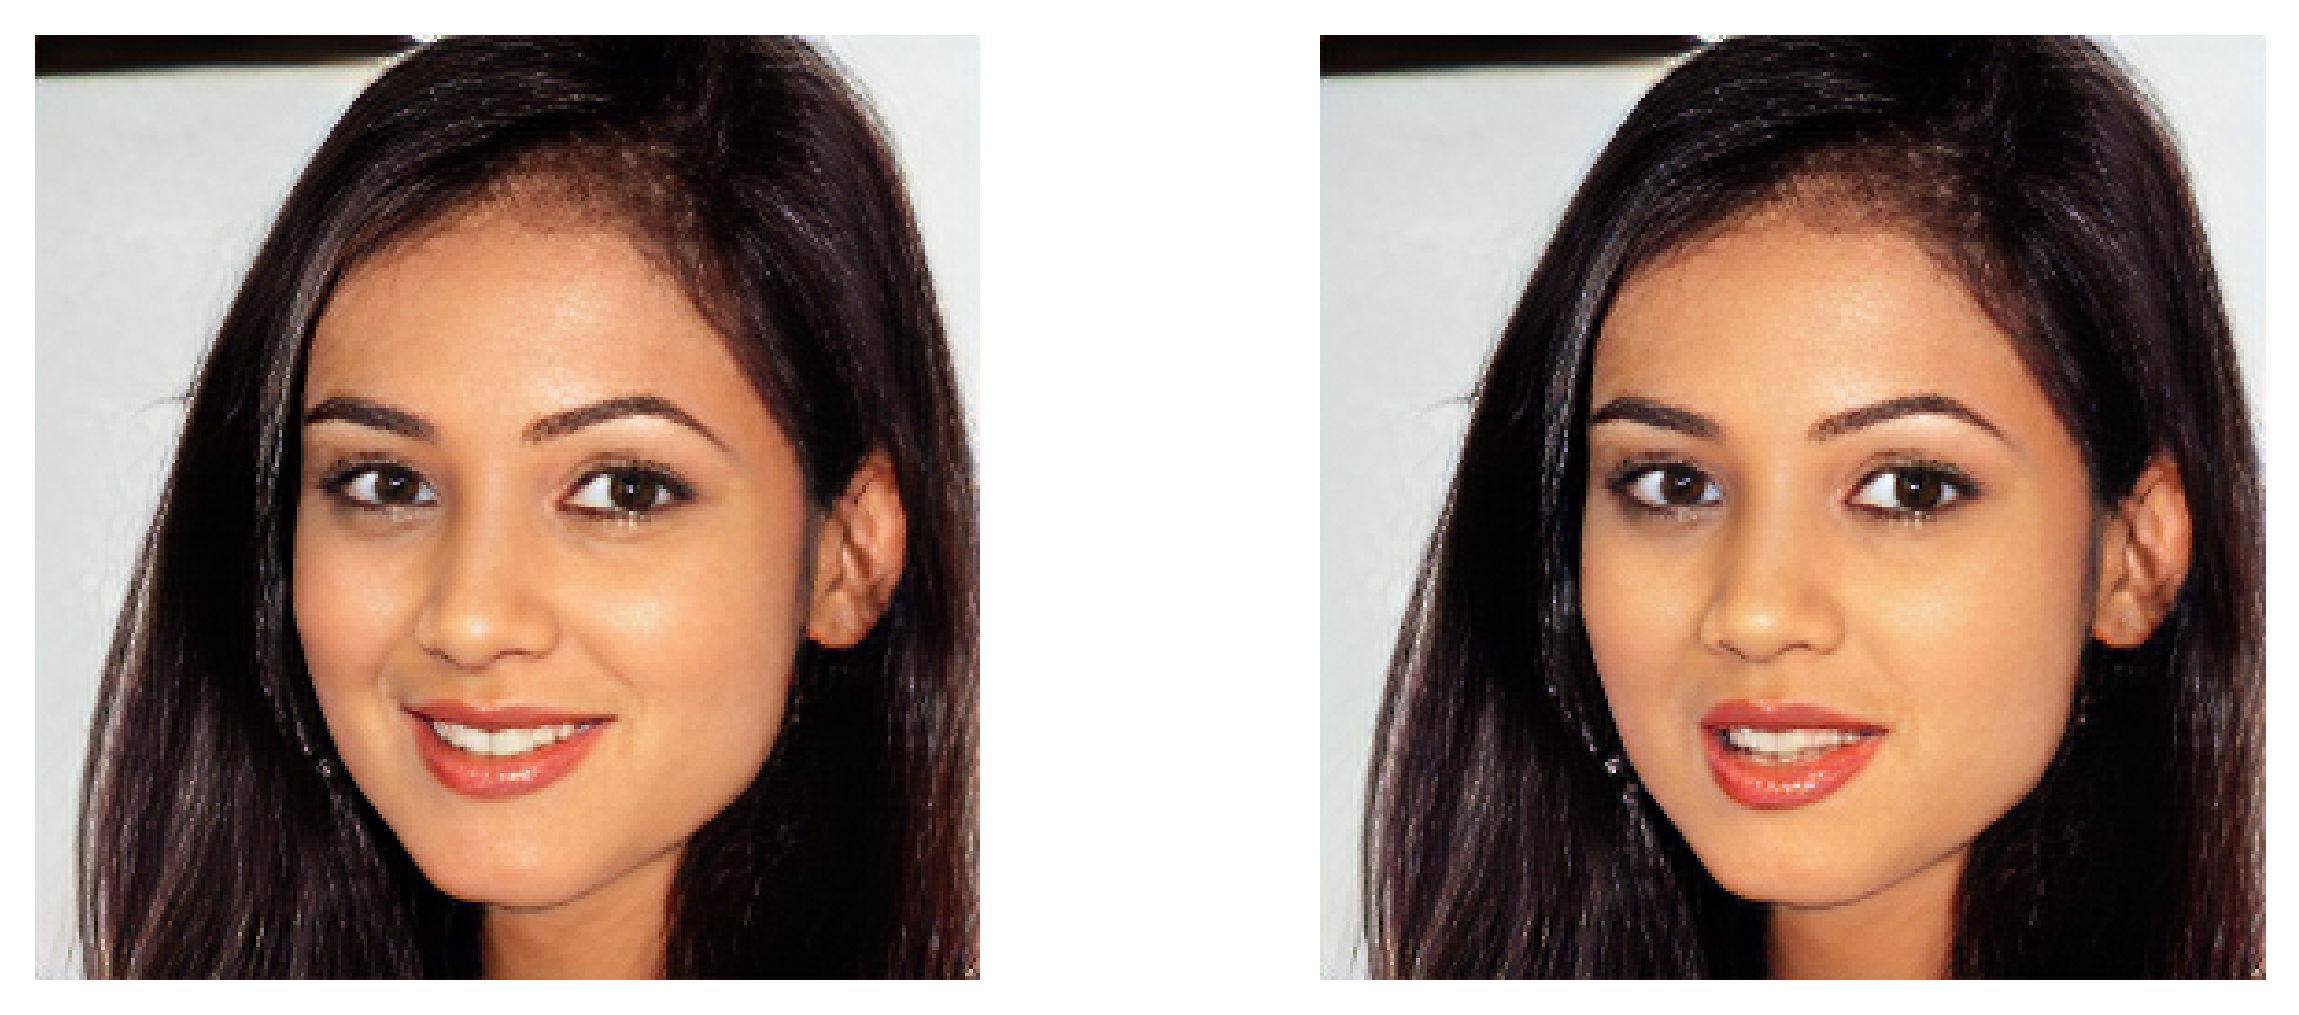

In [17]:
images_f = [h.transpose(1, 2, 0) for h in output["generated_images"]]
fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(8,3), dpi=350)
for i, img in enumerate([images_f[-1], images_f[0]]):
    axs[0, i].imshow(img, interpolation='none')
    axs[0, i].axis('off');
fig.tight_layout()

In [29]:
# latentshift.video_utils.generate_video(output, "test", 
#      ffmpeg_path='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg')

In [19]:
align_dict = latentshift.alignment.compute_alignment_from_output(
    output,
    base_model,
    models,
    ae,
)

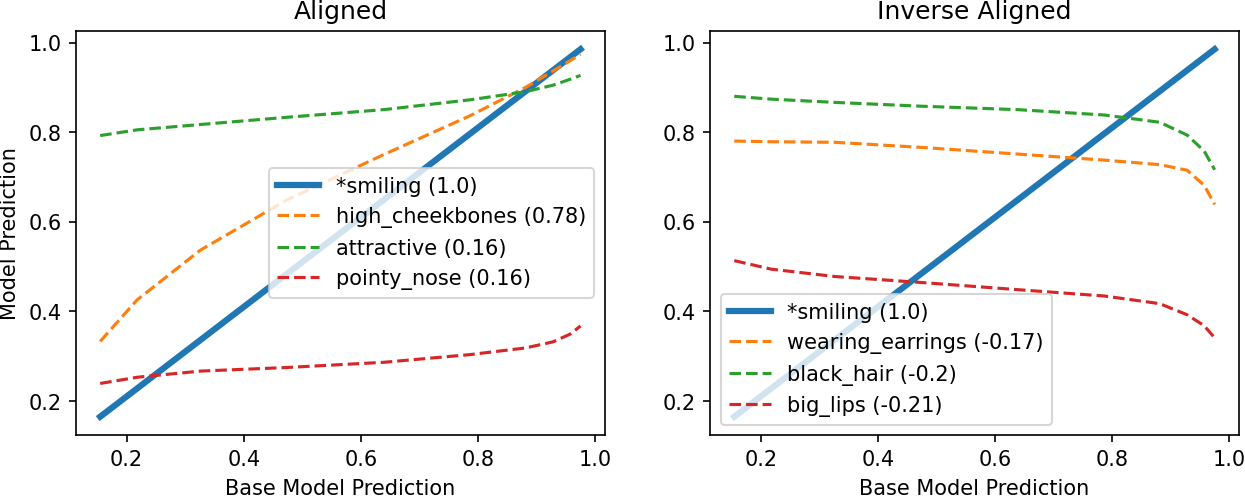

In [28]:
row = align_dict
preds = row['preds'].copy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3.5), dpi=150)
xbase = [preds[c] for c in preds if '*' in c][0]
base_col = ''
for col in pd.DataFrame(preds):
    rchange = round(latentshift.alignment.compute_rchange(xbase,preds[col]),2)
    label = f'{col} ({rchange})'
    #print(label)
    if col == base_col:
        continue
    if '*' in col:
        base_col = col.split('*')[1]
        preds[col] = np.asarray(preds[col]) + 0.01
        for a in ax:
            a.plot(xbase, preds[col], label=label, ls='-', linewidth=3)
    else:
        if (rchange < -0.1):
            ax[1].plot(xbase, preds[col], label=label, ls='--', linewidth=1.5)
        if (rchange > 0.1):
            ax[0].plot(xbase, preds[col], label=label, ls='--', linewidth=1.5)
        # if col == "arched_eyebrows":
        #     ax[0].plot(xbase, preds[col], label=label, ls='--', linewidth=1.5)
ax[0].set_title('Aligned');
ax[0].set_xlabel('Base Model Prediction');
ax[1].set_title('Inverse Aligned');
ax[1].set_xlabel('Base Model Prediction');
ax[0].set_ylabel('Model Prediction');
ax[0].legend();
ax[1].legend();